In [9]:
#54-36-10 with for 90%(20%augmented, 80%validation) and 10%test data
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers

from tensorflow.keras.applications.resnet50 import ResNet50

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
import os

In [12]:
#changing the working directory
%cd /content/gdrive/My Drive/Thesis

/content/gdrive/My Drive/Thesis


In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.applications import VGG19
import cv2
import os
import random
import tensorflow as tf

In [15]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [16]:
data = get_data("/content/gdrive/My Drive/Thesis/flowers")

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.1.2) /io/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



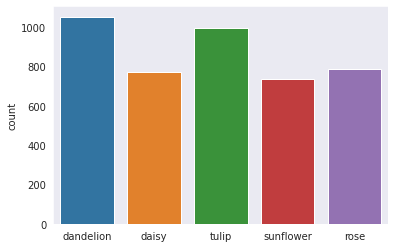

In [17]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

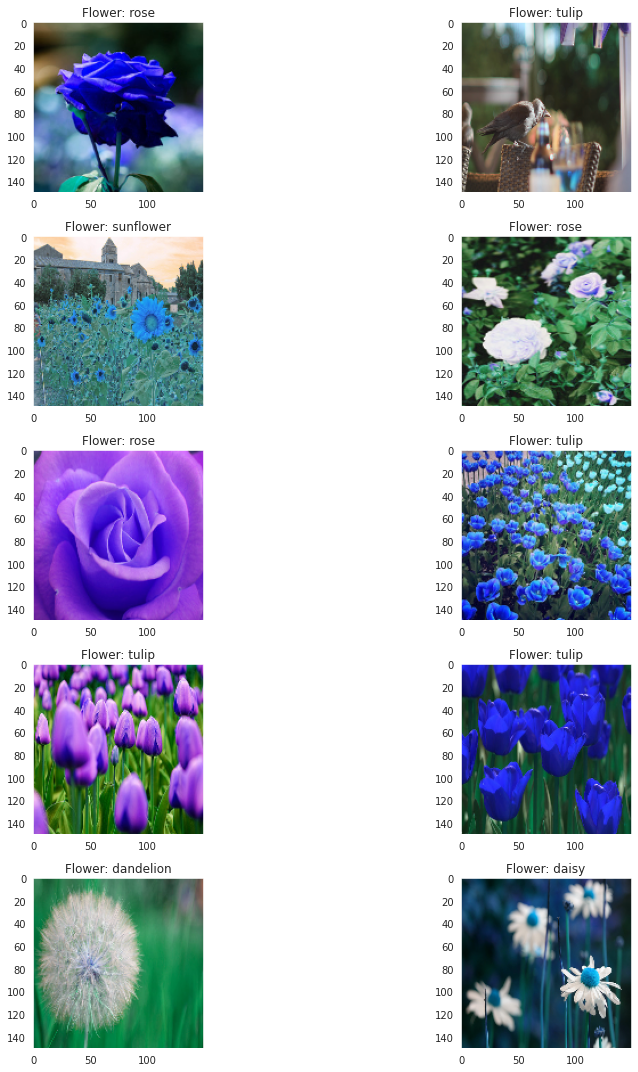

In [18]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

In [19]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [20]:
# Normalize the data
x = np.array(x) / 255

In [21]:
# Reshaping the data from 1-D to 3-D as required through input by CNN's 
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [22]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.1 , random_state = 42)

In [24]:
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size= 0.8, random_state = 42)

In [25]:
#defining the augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=30,  # randomly rotate images in the range (60, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode = "reflect"
    ) 
datagen.fit(x_train)


In [26]:
model = Sequential()

#Adding ResNet model
model.add(ResNet50(include_top=False, pooling='avg', weights="imagenet", input_shape=(150,150,3)))
model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

#Output layer
model.add(Dense(5, activation='softmax'))

model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,695,109
Trainable params: 25,639,941
Non

In [27]:
#defining early stopping
from keras.callbacks import ReduceLROnPlateau
learning_rate = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1,factor=0.5, min_lr=0.000001)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=1, mode='min')

In [28]:
!pip install h5py
	
	
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [29]:
model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [35]:
#Fitting the augmentation data
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data = (x_val, y_val), callbacks = [learning_rate,es,mc])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.0901 - accuracy: 0.9769 
Epoch 00001: val_accuracy improved from 0.24359 to 0.25288, saving model to best_model.h5
25/25 [==============================] - 484s 19s/step - loss: 0.0901 - accuracy: 0.9769 - val_loss: 1.8663 - val_accuracy: 0.2529
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9628 
Epoch 00002: val_accuracy improved from 0.25288 to 0.27308, saving model to best_model.h5
25/25 [==============================] - 483s 19s/step - loss: 0.1018 - accuracy: 0.9628 - val_loss: 1.8861 - val_accuracy: 0.2731
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.0776 - accuracy: 0.9769 
Epoch 00003: val_accuracy improved from 0.27308 to 0.30353, saving model to best_model.h5
25/25 [==============================] - 483s 19s/step - loss: 0.0776 - accuracy: 0.9769 - val_loss: 1.8376 - val_accuracy: 0.3035
Epoch 4/100
25/25 [==============================

In [36]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

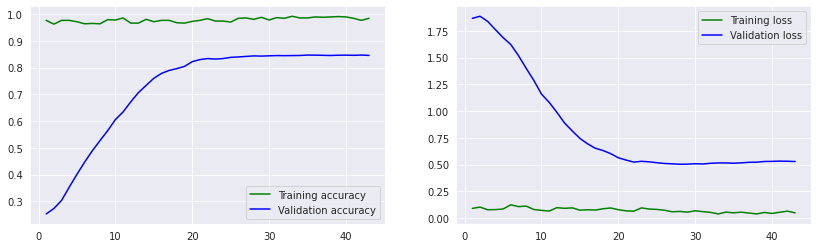

In [37]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, accuracy, 'g', label='Training accuracy')
axes[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'g', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [38]:
saved_model = tf.keras.models.load_model('best_model.h5')
print("Test Accuracy: {0:.2f}%".format(saved_model.evaluate(x_test,y_test)[1]*100)) #get score acording to test datas

14/14 [==============================] - 29s 2s/step - loss: 0.4961 - accuracy: 0.8502
Test Accuracy: 85.02%


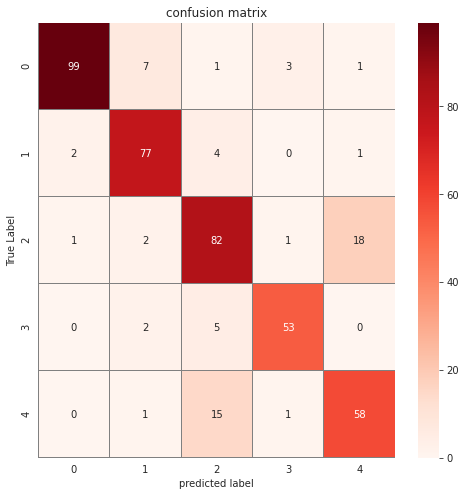

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       111
           1       0.87      0.92      0.89        84
           2       0.77      0.79      0.78       104
           3       0.91      0.88      0.90        60
           4       0.74      0.77      0.76        75

    accuracy                           0.85       434
   macro avg       0.85      0.85      0.85       434
weighted avg       0.85      0.85      0.85       434

              precision    recall  f1-score   support

   dandelion       0.97      0.89      0.93       111
       daisy       0.87      0.92      0.89        84
       tulip       0.77      0.79      0.78       104
   sunflower       0.91      0.88      0.90        60
        rose       0.74      0.77      0.76        75

    accuracy                           0.85       434
   macro avg       0.85      0.85      0.85       434
weighted avg       0.85      0.85      0.85       434



In [39]:
from sklearn.metrics import confusion_matrix
Y_pred = saved_model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Reds",
            linecolor = "gray",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))


y_test_inv = label_binarizer.inverse_transform(y_test)
print(classification_report(y_test_inv, Y_pred_classes, target_names = labels))